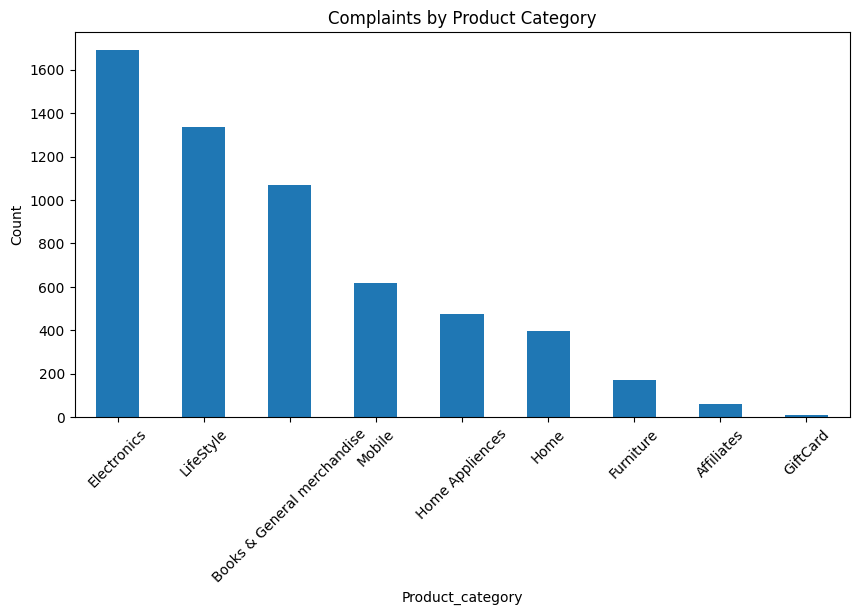

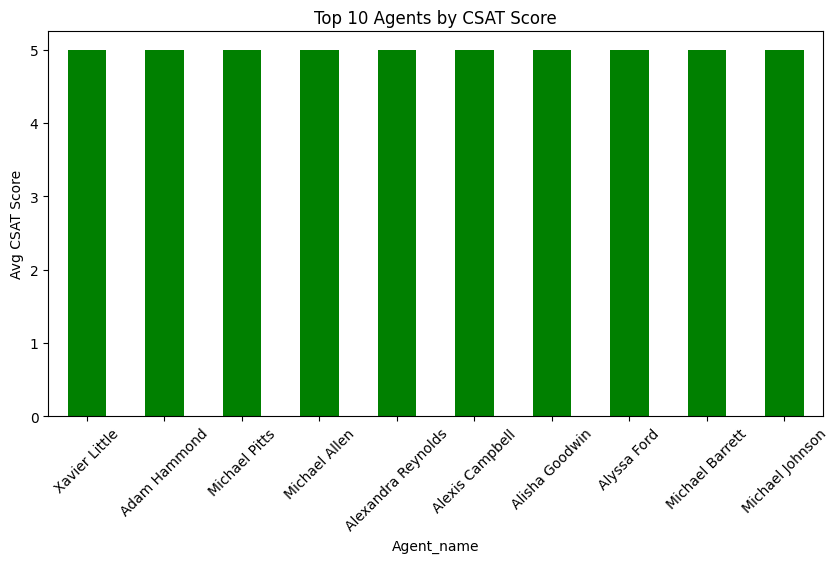

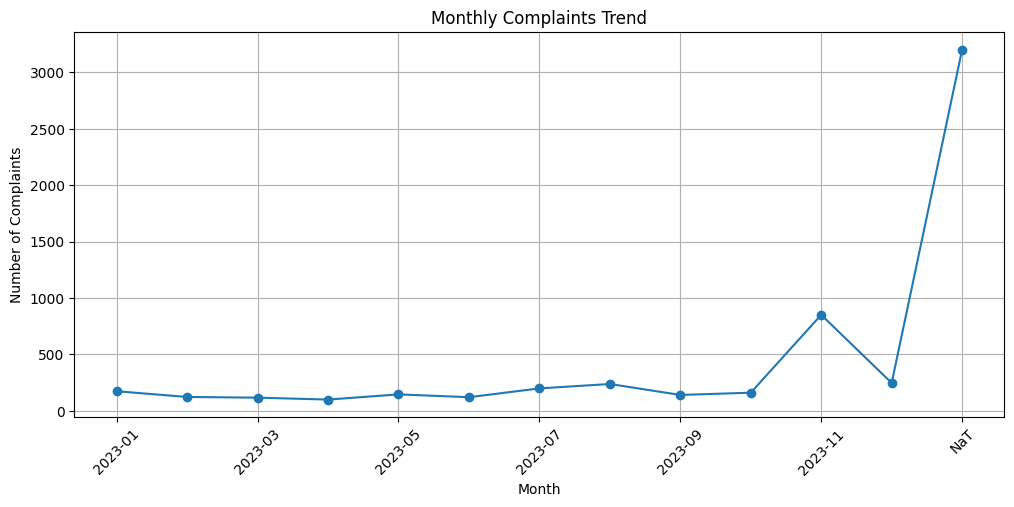

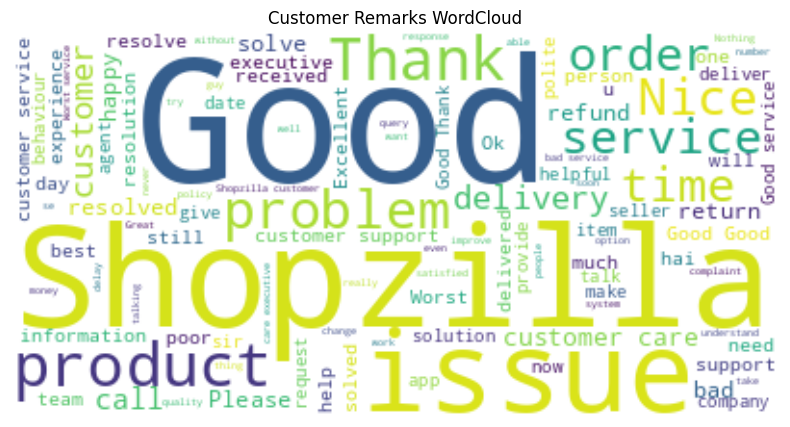

CSAT Prediction - Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.61      0.66       353
           1       0.84      0.89      0.86       811

    accuracy                           0.81      1164
   macro avg       0.77      0.75      0.76      1164
weighted avg       0.80      0.81      0.80      1164

Confusion Matrix:
 [[216 137]
 [ 89 722]]

Cross-validation Accuracy Scores: [0.81271478 0.83505155 0.78522337 0.79209622 0.79381443]
Mean Accuracy: 0.8038


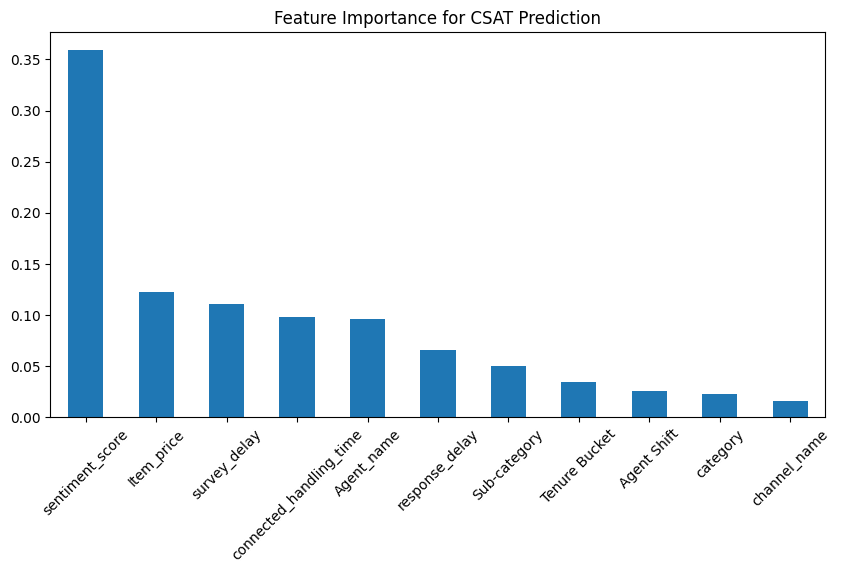


Agent Clustering Silhouette Score: 0.8442


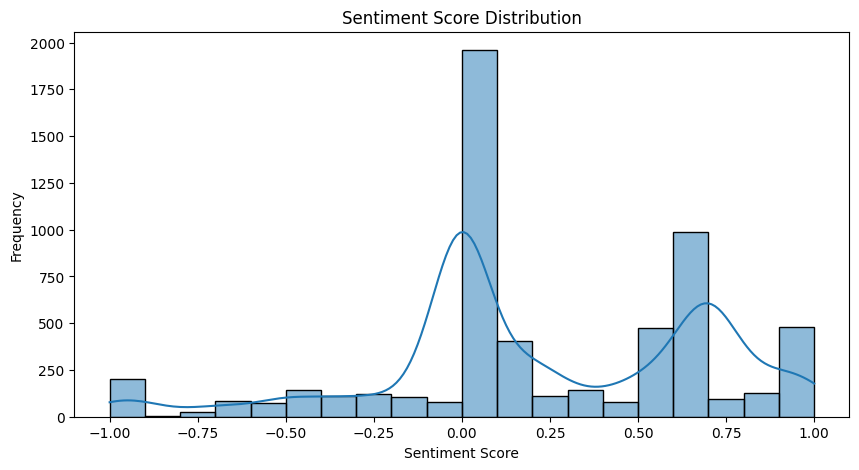

In [ ]:
# Install necessary libraries (run in Colab or Jupyter if needed)
!pip install -q pandas matplotlib seaborn scikit-learn plotly wordcloud textblob

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/content/Customer_support_data.csv')

# ========================
# DATA CLEANING & PREPROCESSING
# ========================

# Remove rows where Product_category or Customer Remarks are empty or NaN
df = df[~df['Product_category'].isnull() & df['Product_category'].str.strip().ne('')]
df = df[~df['Customer Remarks'].isnull() & df['Customer Remarks'].str.strip().ne('')]

# Define column types
string_cols = ['channel_name', 'category', 'Sub-category', 'Customer Remarks', 'Customer_City',
               'Product_category', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift']
numeric_cols = ['Item_price', 'connected_handling_time', 'CSAT Score']

# Fill missing string columns with "Unknown"
for col in string_cols:
    df[col] = df[col].fillna('Unknown')

# Fill missing numeric values with sampled values from normal distribution
for col in numeric_cols:
    if df[col].isnull().any():
        mean, std = df[col].mean(), df[col].std()
        missing_count = df[col].isnull().sum()
        df.loc[df[col].isnull(), col] = np.random.normal(mean, std, size=missing_count)

# Convert date columns
date_cols = ['order_date_time', 'Issue_reported at', 'issue_responded', 'Survey_response_Date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Feature Engineering: time differences
df['response_delay'] = (df['issue_responded'] - df['Issue_reported at']).dt.total_seconds() / 3600
df['survey_delay'] = (df['Survey_response_Date'] - df['order_date_time']).dt.total_seconds() / 3600
df['response_delay'].fillna(df['response_delay'].median(), inplace=True)
df['survey_delay'].fillna(df['survey_delay'].median(), inplace=True)

# Sentiment Analysis
df['sentiment_score'] = df['Customer Remarks'].apply(lambda x: TextBlob(x).sentiment.polarity)

# ========================
# EXPLORATORY DATA ANALYSIS
# ========================

# Complaints by Product Category
plt.figure(figsize=(10, 5))
df['Product_category'].value_counts().plot(kind='bar', title='Complaints by Product Category')
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Top 10 Agents by CSAT Score
top_agents = df.groupby('Agent_name')['CSAT Score'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_agents.plot(kind='bar', color='green', title='Top 10 Agents by CSAT Score')
plt.xticks(rotation=45)
plt.ylabel("Avg CSAT Score")
plt.show()

# Monthly Complaints Trend
df['Month'] = df['Issue_reported at'].dt.to_period('M').astype(str)
monthly_issues = df['Month'].value_counts().sort_index()
plt.figure(figsize=(12, 5))
monthly_issues.plot(kind='line', marker='o', title='Monthly Complaints Trend')
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# WordCloud of Customer Remarks
text = " ".join(df['Customer Remarks'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Customer Remarks WordCloud")
plt.show()

# ========================
# CSAT SCORE PREDICTION
# ========================

df['CSAT_binary'] = df['CSAT Score'].apply(lambda x: 1 if x >= 4 else 0)

# Encode categorical variables
df_encoded = df.copy()
le = LabelEncoder()
for col in string_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Features for model
features = ['channel_name', 'category', 'Sub-category', 'Item_price', 'connected_handling_time',
            'response_delay', 'survey_delay', 'sentiment_score', 'Agent_name', 'Agent Shift', 'Tenure Bucket']
X = df_encoded[features].fillna(0)
y = df_encoded['CSAT_binary']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print("CSAT Prediction - Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation
scores = cross_val_score(clf, X, y, cv=5)
print(f"\nCross-validation Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")

# Feature Importance
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
importances.plot(kind='bar', title='Feature Importance for CSAT Prediction')
plt.xticks(rotation=45)
plt.show()

# ========================
# AGENT CLUSTERING
# ========================

agent_perf = df.groupby('Agent_name')[['CSAT Score', 'response_delay', 'sentiment_score']].mean().fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42)
agent_perf['cluster'] = kmeans.fit_predict(agent_perf)

silhouette = silhouette_score(agent_perf[['CSAT Score', 'response_delay', 'sentiment_score']], agent_perf['cluster'])
print(f"\nAgent Clustering Silhouette Score: {silhouette:.4f}")

# Cluster plot
fig = px.scatter(agent_perf, x='response_delay', y='CSAT Score', color=agent_perf['cluster'].astype(str),
                 hover_name=agent_perf.index, title='Agent Clustering by Performance')
fig.show()

# ========================
# SENTIMENT SCORE DISTRIBUTION
# ========================

plt.figure(figsize=(10, 5))
sns.histplot(df['sentiment_score'], bins=20, kde=True)
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


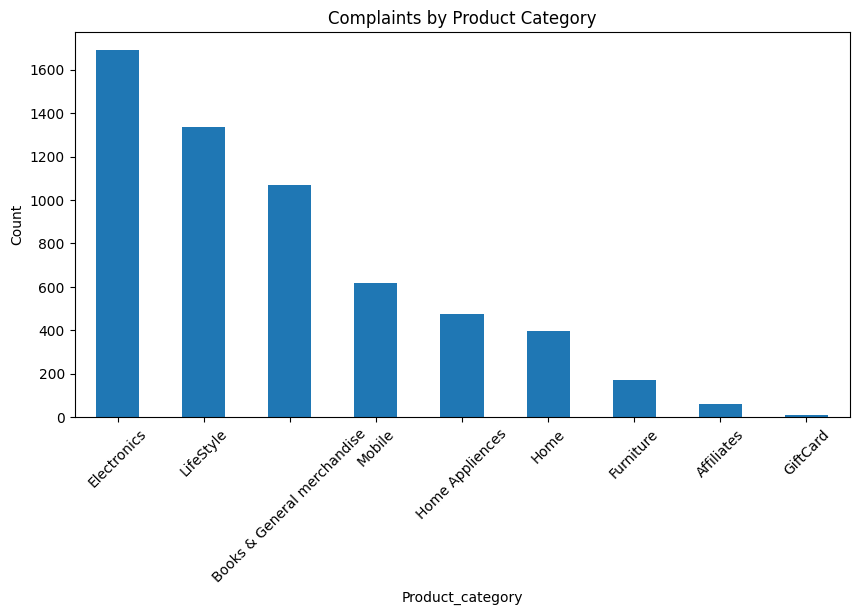

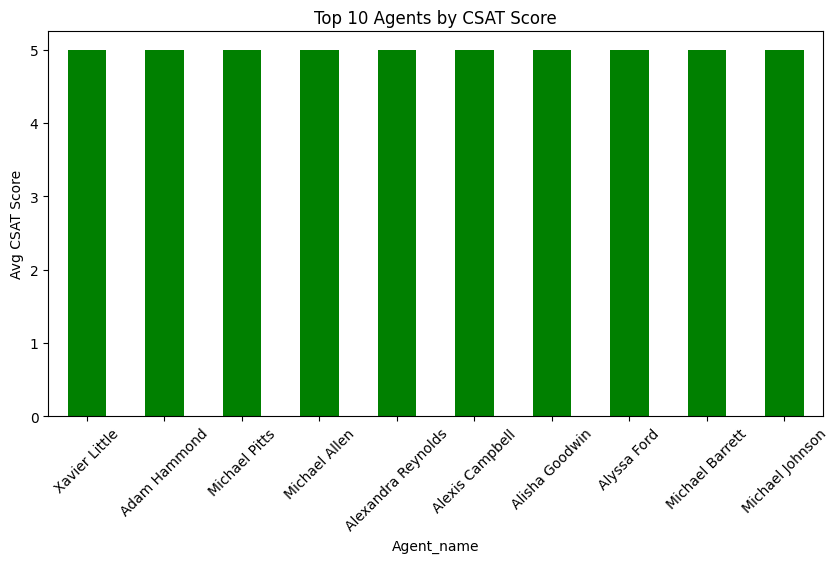

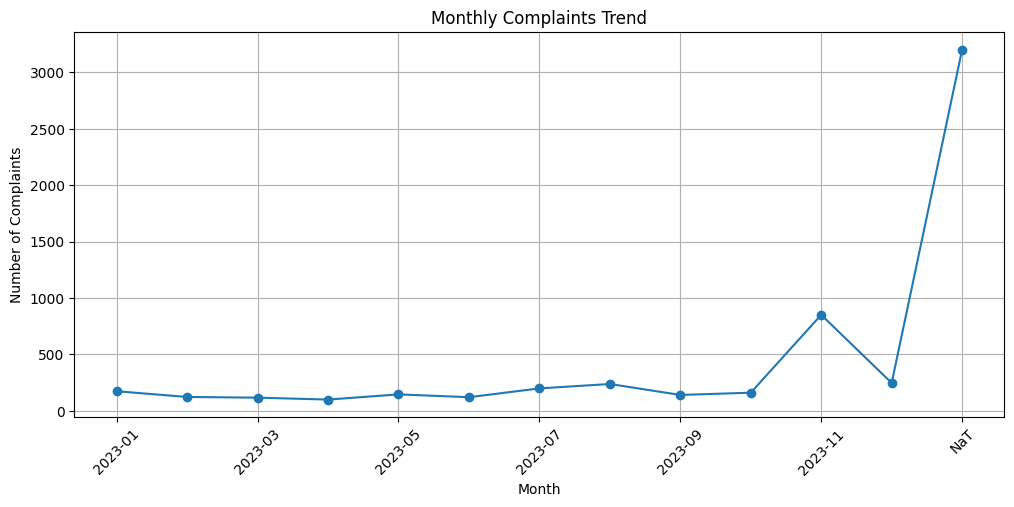

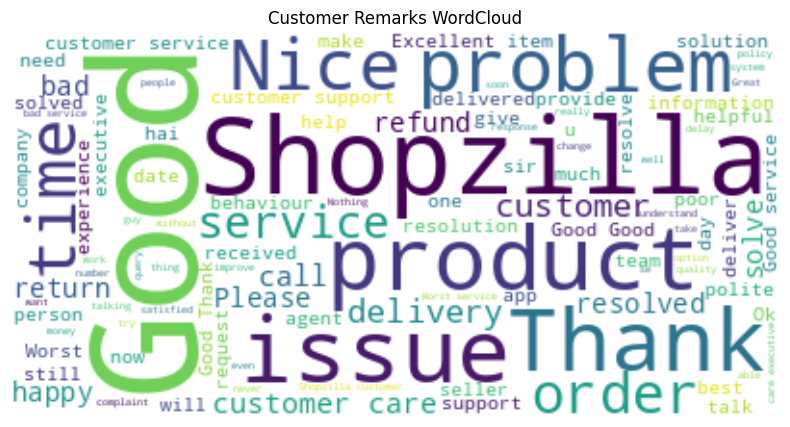

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.59      0.66       353
           1       0.84      0.91      0.87       811

    accuracy                           0.82      1164
   macro avg       0.79      0.75      0.77      1164
weighted avg       0.81      0.82      0.81      1164

Confusion Matrix:
 [[208 145]
 [ 70 741]]
Accuracy: 0.8153
ROC-AUC: 0.7515


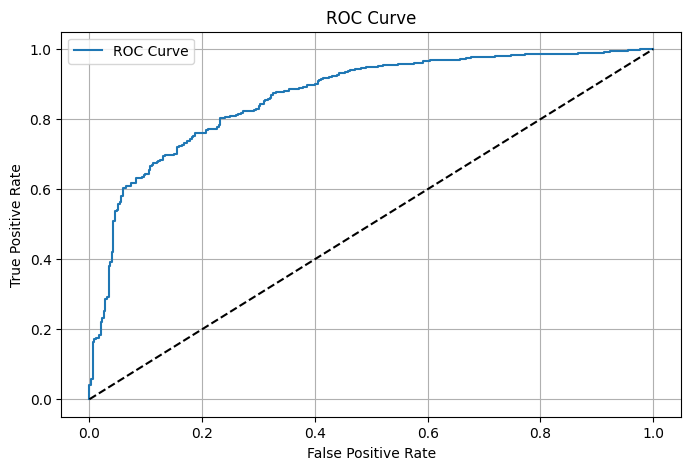


Cross-validation Scores: [0.81443299 0.84106529 0.80584192 0.79553265 0.79295533]
Mean Accuracy: 0.8100


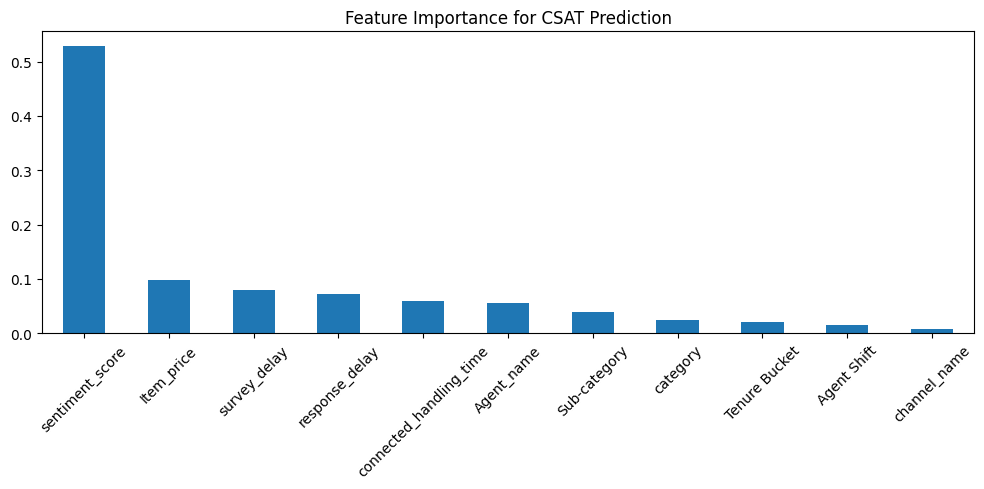


Agent Clustering Silhouette Score: 0.8442


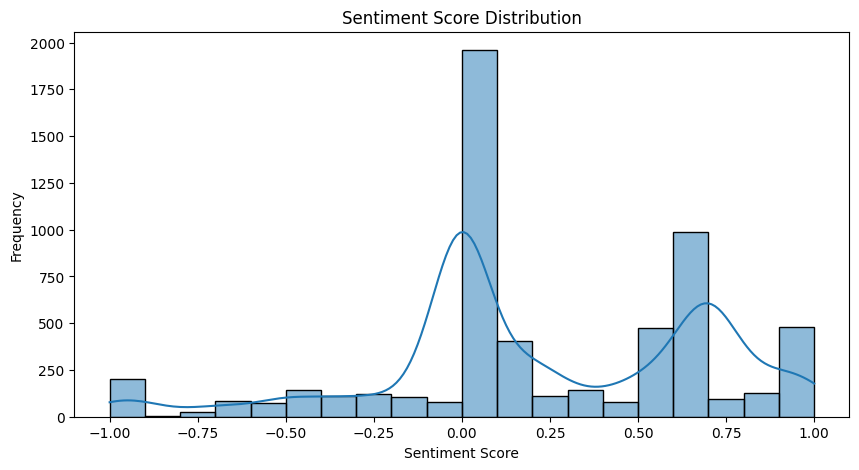

In [ ]:
# Install libraries (if using Colab or Jupyter)
!pip install -q pandas matplotlib seaborn scikit-learn plotly wordcloud textblob


# Imports
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score, roc_auc_score, roc_curve
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/content/Customer_support_data.csv')

# ========================
# DATA CLEANING & PREPROCESSING
# ========================
df = df[~df['Product_category'].isnull() & df['Product_category'].str.strip().ne('')]
df = df[~df['Customer Remarks'].isnull() & df['Customer Remarks'].str.strip().ne('')]

string_cols = ['channel_name', 'category', 'Sub-category', 'Customer Remarks', 'Customer_City',
               'Product_category', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift']
numeric_cols = ['Item_price', 'connected_handling_time', 'CSAT Score']

for col in string_cols:
    df[col] = df[col].fillna('Unknown')

for col in numeric_cols:
    if df[col].isnull().any():
        mean, std = df[col].mean(), df[col].std()
        df.loc[df[col].isnull(), col] = np.random.normal(mean, std, size=df[col].isnull().sum())

date_cols = ['order_date_time', 'Issue_reported at', 'issue_responded', 'Survey_response_Date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['response_delay'] = (df['issue_responded'] - df['Issue_reported at']).dt.total_seconds() / 3600
df['survey_delay'] = (df['Survey_response_Date'] - df['order_date_time']).dt.total_seconds() / 3600
df['response_delay'].fillna(df['response_delay'].median(), inplace=True)
df['survey_delay'].fillna(df['survey_delay'].median(), inplace=True)

df['sentiment_score'] = df['Customer Remarks'].apply(lambda x: TextBlob(x).sentiment.polarity)

# ========================
# EXPLORATORY DATA ANALYSIS
# ========================
plt.figure(figsize=(10, 5))
df['Product_category'].value_counts().plot(kind='bar', title='Complaints by Product Category')
plt.xticks(rotation=45); plt.ylabel("Count"); plt.show()

top_agents = df.groupby('Agent_name')['CSAT Score'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_agents.plot(kind='bar', color='green', title='Top 10 Agents by CSAT Score')
plt.xticks(rotation=45); plt.ylabel("Avg CSAT Score"); plt.show()

df['Month'] = df['Issue_reported at'].dt.to_period('M').astype(str)
monthly_issues = df['Month'].value_counts().sort_index()
plt.figure(figsize=(12, 5))
monthly_issues.plot(kind='line', marker='o', title='Monthly Complaints Trend')
plt.ylabel("Number of Complaints"); plt.xticks(rotation=45); plt.grid(True); plt.show()

text = " ".join(df['Customer Remarks'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear'); plt.axis('off'); plt.title("Customer Remarks WordCloud")
plt.show()

# ========================
# CSAT SCORE PREDICTION
# ========================
df['CSAT_binary'] = df['CSAT Score'].apply(lambda x: 1 if x >= 4 else 0)

df_encoded = df.copy()
le = LabelEncoder()
for col in string_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

features = ['channel_name', 'category', 'Sub-category', 'Item_price', 'connected_handling_time',
            'response_delay', 'survey_delay', 'sentiment_score', 'Agent_name', 'Agent Shift', 'Tenure Bucket']
X = df_encoded[features]
y = df_encoded['CSAT_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
clf = grid.best_estimator_

y_pred = clf.predict(X_test)

# Evaluation
print("Best Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(); plt.grid(); plt.show()

# Cross-validation
scores = cross_val_score(clf, X, y, cv=5)
print(f"\nCross-validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")

# Feature Importance
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
importances.plot(kind='bar', title='Feature Importance for CSAT Prediction')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Save model
joblib.dump(clf, 'csat_predictor_model.joblib')
label_encoders = {}
for col in string_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

joblib.dump(label_encoders, 'label_encoders.joblib')
# ========================
# AGENT CLUSTERING
# ========================
agent_perf = df.groupby('Agent_name')[['CSAT Score', 'response_delay', 'sentiment_score']].mean().fillna(0)
agent_perf['cluster'] = pd.Series(
    KMeans(n_clusters=3, random_state=42).fit_predict(agent_perf),
    index=agent_perf.index
)

silhouette = silhouette_score(agent_perf[['CSAT Score', 'response_delay', 'sentiment_score']], agent_perf['cluster'])
print(f"\nAgent Clustering Silhouette Score: {silhouette:.4f}")

fig = px.scatter(agent_perf, x='response_delay', y='CSAT Score', color=agent_perf['cluster'].astype(str),
                 hover_name=agent_perf.index, title='Agent Clustering by Performance')
fig.show()

# ========================
# SENTIMENT SCORE DISTRIBUTION
# ========================
plt.figure(figsize=(10, 5))
sns.histplot(df['sentiment_score'], bins=20, kde=True)
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()
